In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from IPython.display import display, Latex
from sympy import *
from sympy.interactive import printing
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter, EngFormatter
from scipy import stats
from math import log10
import os
from PyLTSpice import LTSpice_RawRead
printing.init_printing(use_latex=True)

Found Numpy. WIll be used for storing data


In [31]:
R1 = symbols('R1', real=True, positive=True)
R2 = symbols('R2', real=True, positive=True)
R3 = symbols('R3', real=True, positive=True)
R4 = symbols('R4', real=True, positive=True)
C = symbols('C', real=True, positive=True)
#Rp = symbols('R_p', real=True, positive=True)
#Cp = symbols('C_p', real=True, positive=True)
t = symbols('t', real=True, positive=True)
Va = symbols('V_a', real=True)
Vl = symbols('V_l', real=True)
Vin = symbols('V_in', real=True)
io = symbols('i_o', real=True)
iin = symbols('i_in', real=True, positive=True)

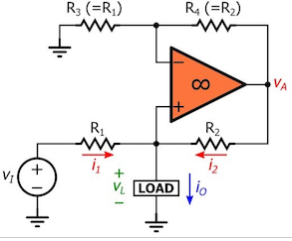

In [ ]:

i1 = (Vin-Vl)/R1
i2 = (Va-Vl)/R2

eq1 = i1 + i2 - io
eq2 = Va - (1+R4/R3)*Vl
eq1
eq2

In [ ]:
Va_ = solveset(eq2, Va).args[0] 
Va_


In [ ]:
eq3 = eq1.subs({Va:Va_})
collect(expand(eq3), Vl)

In [ ]:
io = solveset(eq3, io).args[0]
io

In [ ]:
collect(expand(io), Vl )

In [ ]:
io
Vl
Zo = Vl/io
Zo

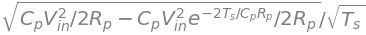

In [39]:
Rp = symbols('R_p', real=True, positive=True)
Cp = symbols('C_p', real=True, positive=True)
t = symbols('t', real=True, positive=True)
Ts = symbols('T_s', real=True, positive=True)
i_prb = (Vin/Rp)*exp(-t/(Rp*Cp))
i_prb
i_rms = sqrt(integrate(i_prb**2, (t, 0, Ts))/Ts)
i_rms
i_rmsf = lambdify((Rp, Cp, Ts, Vin), i_rms)
#i_rms.evalf(subs={Rp:1e6, Cp:200e-12, Vin:5, Ts:})


In [43]:
irms = i_rmsf(Rp, Cp[-1], Ts, Vcc)
irms

In [ ]:
Zo = 1 /collect(expand(io), Vl).coeff(Vl, 1)
#Zo = Vl / io
Zo
Zo.subs({R1: 10e3, R2:10e3, R3:10e3, R4:10e3})

In [47]:
Cp = np.linspace(1e-12, 200e-12, 100) # the probe capacitance
Rp= 1e6  #the resistor forming the RC with the probe
Rh = 100 #the resistor programming the integrating current
Vcc = 5
ic = Vcc/Rh #the integrating current
Cint = 4e-6 #the itegrating capacitor
tau = Rp*Cp #trip point is 2*tau
#find Vpk as function of Cp
#(1-1/np.exp(1)) = .632
#(1-1/np.exp(2)) = .865
tript = 2*Rp*Cp[-1]
print('longest pulse = {:.3e}sec = {:.0f}usec'.format(tript, tript*1e6))

Vpk = ic*2*tau/Cint #q = cv = ic*tau
slope2 = ic*2*Rp/Cint # V/pf = Vpk/Cint = ic*2*tau/(Cint*Cint) = 2*ic*Rp/Cint  
print('slope =  {:.3e}V/F = {:.3f}V/pF = {:.1f}mV/pF'.format(slope2, slope2/1e12, slope2*1e3/1e12))
print('integrating charge current: {:.3e} = {:.1f}mA'.format(ic, ic*1e3))
D = .25
Ts = (1/D)*tript
f = 1/Ts
irms = i_rmsf(Rp, Cp[-1], Ts, Vcc)
print('duty cycle: {:.2f}'.format(D)) #arbitrarily choose
print('frequency: {:.3e}Hz = {:.3f}kHz'.format(f, f/1e3))
print('probe RMS current: {:.3e} A_rms = {:.3f} uA_rms'.format(irms, irms*1e6))
print('max probe energy: {:.3e} J = {:.4f} uJ'.format(.5*Cp[-1]*(Vpk[-1]**2), .5*Cp[-1]*(Vpk[-1]**2)*1e6))
slope, intercept, r_value, p_value, std_err = stats.linregress(Cp, Vpk)


longest pulse = 4.000e-04sec = 400usec
slope =  2.500e+10V/F = 0.025V/pF = 25.0mV/pF
integrating charge current: 5.000e-02 = 50.0mA
duty cycle: 0.25
frequency: 6.250e+02Hz = 0.625kHz
probe RMS current: 1.250e-06 A_rms = 1.250 uA_rms
max probe energy: 2.500e-09 J = 0.0025 uJ


In [56]:
Rset = (1e6*50e3)/(1024*f) #Rset has to be between 50K and 800K
mod = D*.8+.1
a = 1/mod - 1
Rtop = Rset*a/(1+a)
Rbot = Rset - Rtop
print('Rset total = {:.2e}'.format(Rset))
print('Rtop = {:.2e}'.format(Rtop))
print('Rbot = {:.2e}'.format(Rbot))
a
mod
Rbot/(Rbot+Rtop)

Rset total = 7.81e+04
Rtop = 5.47e+04
Rbot = 2.34e+04


Text(0.5, 0, 'Probe Capacitance')

Text(0, 0.5, 'Peak Voltage')

Text(0.5, 1.0, 'Ouput Voltage vs Probe Capacitance')

Text(2.1101010101010102e-11, 4.547727272727272, 'Vpk/Cpk = 2.5e+10V/F = 2.5e-02V/pF')

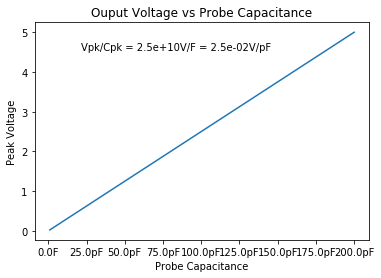

In [57]:
#plot Vpk vs Cprb
fig, ax1 = plt.subplots()
ax1.plot(Cp, Vpk)
major_formatter= EngFormatter(unit='F', places=1, sep='')
ax1.xaxis.set_major_formatter(major_formatter)    
ax1.set_xlabel('Probe Capacitance')
ax1.set_ylabel('Peak Voltage')
ax1.set_title('Ouput Voltage vs Probe Capacitance')
ax1.text(Cp[10], Vpk[90], 'Vpk/Cpk = {:.1e}V/F = {:.1e}V/pF'.format(slope2, slope2/1e12))
#ax1.legend()

In [2]:
path_to_raw = 'C:\\Users\\Erik.Iverson\\Documents\\LTspiceXVII\\RiseTime\\'
raw = os.path.join(path_to_raw+'risetime3.raw')
LTR = LTSpice_RawRead.LTSpiceRawRead(raw) 
out = LTR.get_trace("V(out)").get_wave()
rst = LTR.get_trace("V(rst)").get_wave()
icomm = LTR.get_trace("V(icomm)").get_wave()
iint = LTR.get_trace("I(C1)").get_wave()
vint = LTR.get_trace("V(vint)").get_wave()
Vprb = LTR.get_trace("V(vprb)").get_wave()
t_sim = LTR.get_trace('time').get_time_axis()

Normal access


Text(0, 0.5, 'Voltage')

Text(0, 0.5, 'Current')

Text(0.5, 0, 'Time')

Text(0, 0.5, 'Voltage')

Text(0.5, 0.98, 'One Period of Rise Time Measurement Circuit')

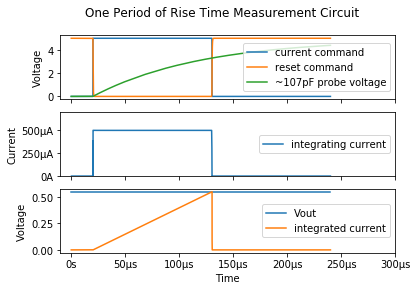

In [3]:
fig, (ax1, ax2,ax3) = plt.subplots(nrows=3, ncols=1, sharex=True)

ax1.plot(t_sim, icomm, label='current command')
ax1.plot(t_sim, rst, label='reset command')
ax1.plot(t_sim, Vprb, label = '~107pF probe voltage')
ax1.set_ylabel('Voltage')
ax1.legend(loc='center right')

ax2.plot(t_sim, iint, label='integrating current')
ax2.set_ylim(top=.7e-3, bottom=0)
ax2.set_ylabel('Current')
ax2.yaxis.set_major_formatter(EngFormatter(unit='A', places=0, sep=''))   
ax2.legend(loc='center right')

ax3.plot(t_sim, out, label='Vout')
ax3.plot(t_sim, vint, label='integrated current')
ax3.set_xlabel('Time')
ax3.set_ylabel('Voltage')
ax3.legend(loc='center right')

ax3.xaxis.set_major_formatter(EngFormatter(unit='s', places=0, sep=''))   
ax3.set_xlim(left=-10e-6, right=300e-6)
fig.suptitle('One Period of Rise Time Measurement Circuit')

In [ ]:
path_to_raw = 'C:\\Users\\Erik.Iverson\\Documents\\LTspiceXVII\\RiseTime\\'
raw = os.path.join(path_to_raw+'risetime4.raw')
LTR = LTSpice_RawRead.LTSpiceRawRead(raw) 
out = LTR.get_trace("V(out)").get_wave()
out2 = LTR.get_trace("V(out2)").get_wave()
#icomm = LTR.get_trace("V(icomm)").get_wave()
#iint = LTR.get_trace("I(C1)").get_wave()
ctl = LTR.get_trace("V(vctl)").get_wave()
t_sim = LTR.get_trace('time').get_time_axis()

In [ ]:
fig,ax1 = plt.subplots(nrows=1, ncols=1)

ax1.plot(t_sim, out, label='Vout')
ax1.plot(t_sim, out2, label='unfiltered Vout')
ax1.set_ylabel('Voltage')


ax1.plot(t_sim, ctl, label='Capacitance Command')
ax1.legend(loc='upper right')
ax1.set_xlabel('Time')
ax1.xaxis.set_major_formatter(EngFormatter(unit='s', places=0, sep=''))   
ax1.set_title('Ramp Response of Rise Time Measurement Circuit')

In [ ]:
path_to_raw = 'C:\\Users\\Erik.Iverson\\Documents\\LTspiceXVII\\RiseTime\\'
raw = os.path.join(path_to_raw+'risetime5.raw')
LTR = LTSpice_RawRead.LTSpiceRawRead(raw) 
out = LTR.get_trace("V(out)").get_wave()
out2 = LTR.get_trace("V(out2)").get_wave()
t_sim = LTR.get_trace('time').get_time_axis()

In [ ]:
fig,ax1 = plt.subplots(nrows=1, ncols=1)
ax1.plot(t_sim, out2, label='unfiltered Vout')
ax1.plot(t_sim, out, label='Vout')

ax1.set_ylabel('Voltage')



ax1.legend(loc='lower right')
ax1.set_xlabel('Time')
ax1.xaxis.set_major_formatter(EngFormatter(unit='s', places=0, sep=''))   
ax1.set_title('Step Response of Rise Time Measurement Circuit')

In [ ]:
fc =178
w = (fc/10)/(2*np.pi)
tau = 1/w
R = 10e3
C = tau/R
C

In [ ]:
2*np.pi/(R*C)
tau